## ENGRI 1120: Direct Calculation of the Total Gibbs Energy for a Reaction Mixture

### Introduction

One method to compute the equilibrium extent of reaction is to _directly_ compute the Gibbs energy for the reaction mixture, and the search over the reaction extent $\epsilon$ that minimizes the Gibbs energy. For a reaction mixture of $\mathcal{M}$ chemical components, the Gbbs energy can be written as the sum of the partial molar Gibbs energies (what we called G-bar) at constant T,P:

$$\hat{G} = \sum_{i\in\mathcal{M}}\bar{G}_{i}n_{i}$$

where $\hat{G}$ denotes the total Gibbs energy for the reaction mixture (units: kJ), $\bar{G}_{i}$ denotes the partial molar Gibbs energy for chemical component $i$ (units: kJ/mol) and $n_{i}$ denotes the number of mols of chemical component $i$. From lecture we know that:

$$\bar{G}_{i} = G_{i}^{\circ} + RT\ln\hat{a}_{i}$$

where $G_{i}^{\circ}$ denotes the Gibbs energy for pure component $i$ at a reference state, and $\hat{a}_{i}$ denotes the ratio of fugacities (mixture at reaction T,P/pure component $i$ at reference conditions). We can subsitute $\bar{G}_{i}$ into the expression for $\hat{G}$, and after some algebraic magic, we get:

$$\epsilon_{1}\frac{\Delta{G}^{\circ}}{RT}+\sum_{i\in\mathcal{M}}\left(n_{i}^{\circ}+\sigma_{i1}\epsilon_{1}\right)\ln\hat{a}_{i} = \frac{1}{RT}\left(\hat{G}-\sum_{i\in\mathcal{M}}n_{i}^{\circ}G_{i}^{\circ}\right)$$

We need to search for $\epsilon_{1}$ such that the total Gibbs energy $\hat{G}$ term on the left-hand side of the expression above is small.

### Example setup

<img src="figs/Fig-G6P-F6P.png" style="width:60%">

To illustrate this idea, let's consider the liquid phase conversion of Glucose-6-Phosphate (G6P) to Fructose-6-Phosphate (F6P) in which we assume _ideal_ liquid phase behavior. We lookup thermodynamic data (the $G_{i}^{\circ}$ values) from [eQuilibrator](https://equilibrator.weizmann.ac.il), and use Julia to compute the total Gibbs energy $\hat{G}$.

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/notebooks-jupyter/ENGRI-1120-DirectGibbsEnergy-Keq`
  No Changes to `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/notebooks-jupyter/ENGRI-1120-DirectGibbsEnergy-Keq/Project.toml`
  No Changes to `~/Desktop/julia_work/ENGRI-1120-IntroToChemE-Example-Notebooks/notebooks-jupyter/ENGRI-1120-DirectGibbsEnergy-Keq/Manifest.toml`


In [2]:
# load reqd packages -
using Optim
using Plots
using Colors

In [10]:
include("ENGRI-1120-Example-CodeLib.jl");

#### Constants

In [6]:
# ideal gas cosntant R -
R = (8.314)*(1/1000)*(1/1000); # units: kJ/mmol-K

# temperature T -
T = 25+273.15; 	# units: K

In [8]:
# number of species and reactions -
ℳ = 2;
ℛ = 1;

# setup the initial number of mols -
initial_mol_array = zeros(ℳ,1)
initial_mol_array[1,1] = 20.0; 	# units: mmol G6P = 1
initial_mol_array[2,1] = 0.0; 		# units: mmol F6P = 2

# G of formation -
G_formation_array = zeros(ℳ,1)
G_formation_array[1,1] = -1304.7*(1/1000); 	# units: kJ/mmol G6P
G_formation_array[2,1] = -1302.1*(1/1000); 	# units: kJ/mmol F6P

# stoichiometric coefficients -
stoichiometric_array = zeros(ℳ,ℛ)
stoichiometric_array[1,1] = -1;
stoichiometric_array[2,1] = 1;

# package -
parameters_dict = Dict{String,Any}()
parameters_dict["initial_mol_array"] = initial_mol_array;
parameters_dict["G_formation_array"] = G_formation_array;
parameters_dict["stoichiometric_array"] = stoichiometric_array;

### a) Directly plot the Gibbs energy curve and look for a minimum

In [11]:
# initialize -
number_of_steps = 100
gibbs_energy_array = Array{Float64,1}()
epsilon_range = range(0.00001,stop=0.99999,length=number_of_steps) |> collect

# compute -
for ϵ in epsilon_range

    gibbs_energy_value = objective_function([ϵ],parameters_dict);
    push!(gibbs_energy_array,gibbs_energy_value)
end

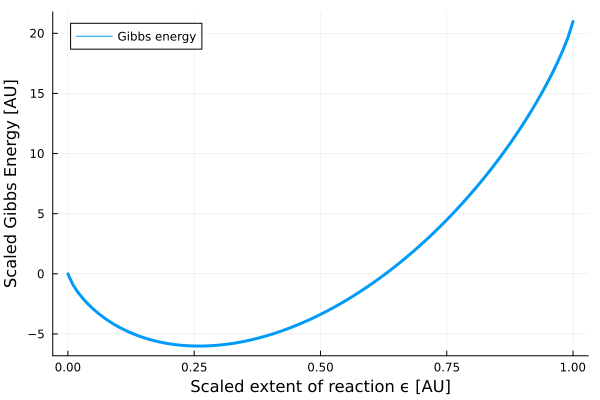

In [12]:
plot(epsilon_range, gibbs_energy_array,lw=3,legend=:topleft, label="Gibbs energy")
xlabel!("Scaled extent of reaction ϵ [AU]",fontsize=18)
ylabel!("Scaled Gibbs Energy [AU]",fontsize=18)

#### where is the min?

In [13]:
# what is the min value of the G energy and the extent?
min_G_ind = argmin(gibbs_energy_array)
min_ϵ_value = epsilon_range[min_G_ind]
min_G_value = gibbs_energy_array[min_G_ind]

# show -
println("Min extent (G,ϵ) = ($(min_G_value),$(min_ϵ_value))")

Min extent (G,ϵ) = (-6.006415766580738,0.2626310101010101)


### b) Optimization
Let's use the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package to recast that as a _constrained_ optimization problem 

In [14]:
# Use the answer from Method 2 as a starting point 
xinitial = [0.9999]

# setup bounds -
L = 0.00001
U = 0.99999

# setup the objective function -
OF(p) = objective_function(p, parameters_dict)

# call the optimizer -
opt_result = optimize(OF,L, U, xinitial, Fminbox(BFGS()))

 * Status: success

 * Candidate solution
    Final objective value:     -6.006945e+00

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 4.43e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.71e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    20
    ∇f(x) calls:   20


In [16]:
ϵ_opt = Optim.minimizer(opt_result)[1]
println("Optim found ϵ = $(ϵ_opt)")

Optim found ϵ = 0.2594389721869081


### c) Compute the Keq

In [33]:
# We use a scaled extent, need to unscale -
ϵ_raw = sum(initial_mol_array)*ϵ_opt;

# compute the final number of moles -
n_final = initial_mol_array + stoichiometric_array*(ϵ_raw);
n_total = sum(n_final);

# compute mol fraction -
x = n_final./n_total;

# compute Keq -
Keq_ϵ = (x[2])/(x[1]);

In [32]:
# check: do we get the same value from ΔG?
ΔG_rxn = -(R*T)*log(Keq_ϵ);

# Compute ΔG from data -
ΔG_data = sum(stoichiometric_array.*G_formation_array);

# print -
println("ΔG_rxn extent = $(ΔG_rxn) kJ/mmol and ΔG_rxn from data = $(ΔG_data) kJ/mmol")

ΔG_rxn extent = 0.0025999999997765037 kJ/mmol and ΔG_rxn from data = 0.0025999999999999357 kJ/mmol
